# Hands-on: Run the AIFS


This notebook describes how to run inference of the AIFS from an existing checkpoint. 


Resources:
[anemoi-inference](https://anemoi-inference.readthedocs.io/en/latest/apis/level1.html) package.

## Install Required Packages and Imports


Fastest installation with `uv`. Get `uv` by running: 
```bash
curl -LsSf https://astral.sh/uv/install.sh | sh

```
Create environment and install required packages:
```bash
uv venv --python=3.12 
source .venv/bin/activate
uv pip install anemoi-training anemoi-models anemoi-inference anemoi-datasets torch torchvision
```

We have already done that for you on the EWC, so you are good to go! 

In [1]:
import datetime
import logging
from collections import defaultdict
import torch
import numpy as np

from anemoi.inference.runners.simple import SimpleRunner
from anemoi.inference.outputs.printer import print_state
LOGGER = logging.getLogger(__name__)

/home/ecm1922/Projects/ml-training-course/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


## Get information from the checkpoint

The checkpoint contains ...


In [2]:
ckpt_file = "../5-xAI-with-AIFS/inference-aifs-o96.ckpt"
ckpt = torch.load(ckpt_file, weights_only=False)

/home/ecm1922/Projects/ml-training-course/.venv/lib/python3.12/site-packages/anemoi/utils/config.py:209: UserWarning: Modifying an instance of DotDict(). This class is intended to be immutable.
  warnings.warn("Modifying an instance of DotDict(). This class is intended to be immutable.")


Variables the model has been trained on:

In [7]:
all_vars = ckpt.data_indices.name_to_index.keys()
forcing_vars = ckpt.data_indices.forcing
diagnostic_vars = ckpt.data_indices.diagnostic
prognostic_vars = [var for var in all_vars if var not in forcing_vars and var not in diagnostic_vars]

print(f"Forcing variables: {forcing_vars}")
print(f"Diagnostic variables: {diagnostic_vars}")
print(f"Prognostic variables: {prognostic_vars}")

Forcing variables: ['cos_latitude', 'cos_longitude', 'sin_latitude', 'sin_longitude', 'cos_julian_day', 'cos_local_time', 'sin_julian_day', 'sin_local_time', 'insolation', 'lsm', 'sdor', 'slor', 'z']
Diagnostic variables: ['tp', 'cp']
Prognostic variables: ['10u', '10v', '2d', '2t', 'msl', 'q_100', 'q_1000', 'q_150', 'q_200', 'q_250', 'q_300', 'q_400', 'q_50', 'q_500', 'q_600', 'q_700', 'q_850', 'q_925', 'skt', 'sp', 't_100', 't_1000', 't_150', 't_200', 't_250', 't_300', 't_400', 't_50', 't_500', 't_600', 't_700', 't_850', 't_925', 'tcw', 'u_100', 'u_1000', 'u_150', 'u_200', 'u_250', 'u_300', 'u_400', 'u_50', 'u_500', 'u_600', 'u_700', 'u_850', 'u_925', 'v_100', 'v_1000', 'v_150', 'v_200', 'v_250', 'v_300', 'v_400', 'v_50', 'v_500', 'v_600', 'v_700', 'v_850', 'v_925', 'w_100', 'w_1000', 'w_150', 'w_200', 'w_250', 'w_300', 'w_400', 'w_50', 'w_500', 'w_600', 'w_700', 'w_850', 'w_925', 'z_100', 'z_1000', 'z_150', 'z_200', 'z_250', 'z_300', 'z_400', 'z_50', 'z_500', 'z_600', 'z_700', 'z_85

The model architecture

In [8]:
ckpt.model

AnemoiModelEncProcDec(
  (node_attributes): NamedNodesAttributes(
    (trainable_tensors): ModuleDict(
      (data): TrainableTensor()
      (hidden): TrainableTensor()
    )
  )
  (encoder): GraphTransformerForwardMapper(
    (activation): GELU(approximate='none')
    (trainable): TrainableTensor()
    (proc): GraphTransformerMapperBlock(
      (lin_key): Linear(in_features=1024, out_features=1024, bias=True)
      (lin_query): Linear(in_features=1024, out_features=1024, bias=True)
      (lin_value): Linear(in_features=1024, out_features=1024, bias=True)
      (lin_self): Linear(in_features=1024, out_features=1024, bias=True)
      (lin_edge): Linear(in_features=11, out_features=1024, bias=True)
      (conv): GraphTransformerConv()
      (projection): Linear(in_features=1024, out_features=1024, bias=True)
      (layer_norm_attention): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (layer_norm_mlp_dst): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (node_ds

In [10]:
print(f"Number of weights: {sum(p.numel() for p in ckpt.model.parameters() if p.requires_grad)}")

Number of weights: 231139096


## Get initial conditions


Running the model for inference requires initial conditions. We can


a. Retrieve Initial Conditions from ECMWF Open Data

b. Use the initial conditions from the anemoi-dataset used for training




### a. Retrieve Initial Conditions from ECMWF Open Data


In [11]:
import datetime
from collections import defaultdict
from pathlib import Path

import numpy as np
import earthkit.data as ekd
import earthkit.regrid as ekr

from ecmwf.opendata import Client as OpendataClient
from helpers import load_saved_state, save_state


In [12]:
R = 6371.0  # Earth radius in km
GRID_RESOLUTION = "O96"
PARAM_SFC = ["10u", "10v", "2d", "2t", "msl", "skt", "sp", "tcw", "lsm", "z", "slor", "sdor"]
PARAM_SOIL = ["vsw", "sot"]
PARAM_PL = ["gh", "t", "u", "v", "w", "q"]
LEVELS = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]
SOIL_LEVELS = [1, 2]

DATE = OpendataClient().latest()
print("Initial date is", DATE)


Initial date is 2025-10-22 06:00:00


In [13]:
def get_open_data(param, levelist=[], reference_date=DATE):
    fields = defaultdict(list)
    # Get the data for the current date and the previous date
    for date in [reference_date - datetime.timedelta(hours=6), reference_date]:
        data = ekd.from_source("ecmwf-open-data", date=date, param=param, levelist=levelist)
        for f in data:
            # Open data is between -180 and 180, we need to shift it to 0-360
            assert f.to_numpy().shape == (721, 1440)
            values = np.roll(f.to_numpy(), -f.shape[1] // 2, axis=1)
            # Interpolate the data to from 0.25 to grid
            values = ekr.interpolate(values, {"grid": (0.25, 0.25)}, {"grid": GRID_RESOLUTION})
            # Add the values to the list
            name = f"{f.metadata('param')}_{f.metadata('levelist')}" if levelist else f.metadata("param")
            fields[name].append(values)

    # Create a single matrix for each parameter
    for param, values in fields.items():
        fields[param] = np.stack(values)

    return fields

Here we make a single forecast, from the control initial condition of the ensemble. In operations, this model is run 51 times, once from the control and 50 more times from slightly different initial conditions. 

To get different ensemble initial conditions from the ifs pertubation, set `number` to an ensemble number, between 1-50.


In [14]:
file = Path(f"inputstate-{DATE.strftime('%Y%m%d_%H')}.npz")
if file.exists():
    input_state = load_saved_state(file)
    LOGGER.info(f"Input state loaded from file {file}")
else:
    fields = {}
    # Surface fields
    fields.update(get_open_data(param=PARAM_SFC, reference_date=DATE))
    # Pressure levels fields
    fields.update(get_open_data(param=PARAM_PL, levelist=LEVELS, reference_date=DATE))
    # Soil parameters
    # fields.update(get_open_data(param=PARAM_SOIL,levelist=SOIL_LEVELS, reference_date=date))
    # fields = rename_keys(fields, {'sot_1': 'stl1', 'sot_2': 'stl2', 'vsw_1': 'swvl1', 'vsw_2': 'swvl2'})

    # Convert geopotential height into geopotential
    for level in LEVELS:
        gh = fields.pop(f"gh_{level}")
        fields[f"z_{level}"] = gh * 9.80665
    
    input_state = dict(date=DATE, fields=fields)

    LOGGER.info(f"State created for date {DATE}")
    save_state(input_state, file)

    LOGGER.info(f"State saved to file {file}")

## Run inference from initial conditions

In [15]:
runner = SimpleRunner(ckpt_file, device="cuda")

### Run the forecast



In [16]:
forecast_states = []
for step, state in enumerate(runner.run(input_state=input_state, lead_time=48)):
    LOGGER.info(f"Step {step}: {state['date']} (lead time: {state['step']})")
    LOGGER.info(f"  Available fields: {list(state['fields'].keys())}")
    # Store the state if you want to keep it
    forecast_states.append(state)

LOGGER.info(f"Forecast completed! Generated {len(forecast_states)} time steps.")

/home/ecm1922/Projects/ml-training-course/.venv/lib/python3.12/site-packages/anemoi/utils/config.py:209: UserWarning: Modifying an instance of DotDict(). This class is intended to be immutable.
  warnings.warn("Modifying an instance of DotDict(). This class is intended to be immutable.")


# 4. Inspect the generated forecast

### Plot a field


In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.tri as tri

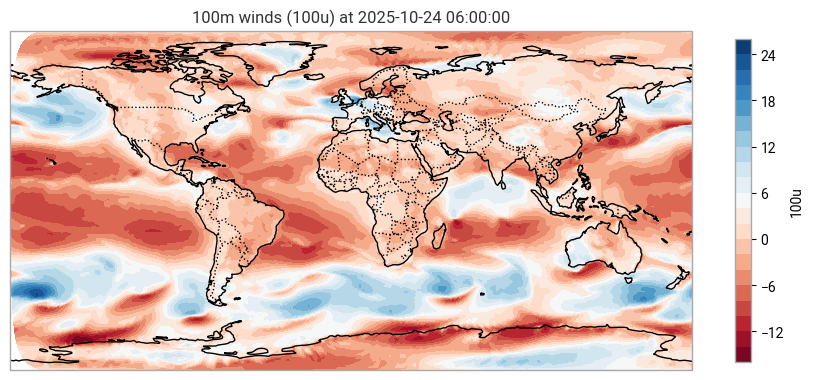

In [18]:
def fix(lons):
    # Shift the longitudes from 0-360 to -180-180
    return np.where(lons > 180, lons - 360, lons)

state = forecast_states[0]
latitudes = state["latitudes"]
longitudes = state["longitudes"]
values = state["fields"]["10u"]

fig, ax = plt.subplots(figsize=(11, 6), subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

triangulation = tri.Triangulation(fix(longitudes), latitudes)

contour=ax.tricontourf(triangulation, values, levels=20, transform=ccrs.PlateCarree(), cmap="RdBu")
cbar = fig.colorbar(contour, ax=ax, orientation="vertical", shrink=0.7, label="100u")

plt.title("100m winds (100u) at {}".format(state["date"]))
plt.show()

### Plot plume